In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
import math
from tensorflow.keras.losses import mse, mae, cosine_similarity, logcosh
from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow_probability as tfp

%matplotlib inline
%load_ext autoreload
%autoreload 2

tf.keras.backend.clear_session()  # For easy reset of notebook state.
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

## prepare data

In [3]:
'''
def make_test_train_split(df_labels, random_state=12):
    idx_train, idx_test = train_test_split(df_labels.ResultFinalCheck, test_size=0.1, random_state=random_state)

    df_train = df_labels.loc[idx_train.index].reset_index(drop=True)
    df_test = df_labels.loc[idx_test.index].reset_index(drop=True)
    
    return df_train, df_test
'''

def plot_curve(df_curve, ax=None):
        
    if not ax:
        _, ax = plt.subplots()
    
    #plt.ylim(0, 50)
    for feature in ['K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC']:
        df_curve[feature].plot(ax=ax, label=feature)
    
    ax.legend(loc='lower right')
    #ax.set_title(df_curve.name)

def parse_curve(filepath):
    """
    Parses the curve into a pandas dataframe
    
    WegSpd1 	mm 	Distance traveld by press
    KraftSpd1 	N 	Force spend by press
    K7_1_TL 	% 	Sharpness value top left
    K7_2_TR 	% 	sharpness value top right
    K7_3_BL 	% 	sharpness value bottom left
    K7_4_BR 	% 	sharpness value bottom right
    K7_5_MC 	% 	sharpness value middle center
    """
    df = pd.read_csv(
        filepath, 
        skiprows=33, 
        delimiter=';', 
        dtype=np.float,
        names=['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC','K_7m)','MT'],
        usecols=range(9)
    )
    #df.name = os.path.basename(filepath)
    #num = df.isna().sum()
    #return df, sum(num)
    return df

In [4]:
class CurveSequence(Sequence):
    """
    Helper class to sample and iterating over the dataset
    
    Args:
        df (pandas.DataFrame): Dataframe holding curve paths and labels
        batch_size (int): The batch size 
        n_timesteps (int): Number of steps to be used from the curves
        curve_path (str): Path to directory where curve folders are located
    """

    def __init__(self, df, batch_size=20, n_timesteps=1800, curve_path='/home/deeplearning/data_disk_2/mpc2_data/'):
        self.df = df.copy()
        self.curve_path = curve_path
        self.batch_size = batch_size
        self.n_timesteps = n_timesteps
        self.window_size = 100
        
    def make_batch(self, df_sub):
        self.window_size = 100
        dfs = [
            parse_curve(
                os.path.join(self.curve_path, filepath)
            ) for filepath in df_sub['FilePath'].values
        ]

        # batch_size * 1800 * 5
        X = np.array([
            #df[0:self.n_timesteps][['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC','K_7m)','MT']].values for df in dfs
            df[0:self.n_timesteps][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values for df in dfs
        ])
        '''
        # MEAN+STD
        MEAN = X.mean(axis=2)
        STD = X.std(axis=2)
        X = np.zeros((len(df_sub['FilePath']),self.n_timesteps,2))
        X[:,:,0] = MEAN
        X[:,:,1] = STD
        '''
        # only STD
        idx = np.arange(0,1800,20)
        X = X[:,idx].std(axis=2)
        
        #print(np.shape(X))
        
        # 9 feature
        #X_mean = np.array([0.163551, 13.586131, 30.917057, 30.875045, 30.826165, 30.879995, 28.995421, 12.470428, -472945.497673])
        #X_std = np.array([6.119196e-02, 1.619622e+01, 1.259245e+01, 1.269009e+01, 1.217232e+01, 1.233527e+01, 1.052125e+01, 1.634376e+01, 2.957244e+06])
        
        # 5 feature
        #X_mean = np.array([30.917057, 30.875045, 30.826165, 30.879995, 28.995421])
        #X_std = np.array([1.259245e+01, 1.269009e+01, 1.217232e+01, 1.233527e+01, 1.052125e+01])
        #X = (X - X_mean) / X_std
        
        # diff between min and max
        #X_max = X.max(axis=2)
        #X_min = X.min(axis=2)
        #X = X_max - X_min
        
        '''
        #moving average
        avg = np.zeros((len(df_sub['FilePath']), 1800, 5))
        for i in range(X.shape[1]):
            temp = np.zeros((len(df_sub['FilePath']), 5))
            for j in range(self.window_size):
                if i+j < X.shape[1]:
                    temp = temp + X[:, i+j]
                else:
                    self.window_size = j
                    break
            temp /= self.window_size
            avg[:, i] = temp
        #print(X.shape, avg.shape)
        X = X - avg
        X = X.std(axis=2)
        '''
        return X

    def __len__(self):
        return math.ceil(self.df.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        df_sub = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        return self.make_batch(df_sub)

In [5]:
df_train = pd.read_csv('pure_train_5_pec_70_pec.csv')
#df_train, df_test = make_test_train_split(df)
df_train.shape

(51973, 2)

## Valid VAE Model

In [6]:
# model setting 
# The number of epochs at which KL loss should be included
klstart = 2
# number of epochs over which KL scaling is increased from 0 to 1
kl_annealtime = 2

weight = tf.keras.backend.variable(0.1)
#temp = tf.keras.backend.variable(1e-10)

class AnnealingCallback(keras.callbacks.Callback):
    def __init__(self, weight):
        self.weight = weight
    def on_epoch_end (self, epoch, logs={}):
        if epoch > klstart :
            new_weight = min(tf.keras.backend.get_value(self.weight) + (1./ kl_annealtime), 1.)
            tf.keras.backend.set_value(self.weight, new_weight)
        print ("Current KL Weight is " + str(tf.keras.backend.get_value(self.weight)))

latent_dim = 50
intermediate_dim = 100

mu_prior =  tf.constant(np.zeros([latent_dim], dtype='float32'))
sigma_prior = tf.constant(np.ones([latent_dim], 'float32'))


# define VAE model
encoder_inputs = keras.Input(shape=(90, 1))
x = layers.Flatten()(encoder_inputs)
h = layers.Dense(intermediate_dim, activation='relu')(x)
h = layers.BatchNormalization()(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = layers.Dense(intermediate_dim, activation='relu')
bn3 = layers.BatchNormalization()
decoder_mean = layers.Dense(90*1, activation='relu')

f_decoded = decoder_h(z)
f_decoded = bn3(f_decoded)
f_decoded = decoder_mean(f_decoded)
#decoder_outputs = layers.Reshape((1800, 1))(x_decoded_mean)
z_mean_post = layers.Dense(90*1)(f_decoded)
z_log_var_post = layers.Dense(90*1)(f_decoded)

z_post = layers.Lambda(sampling, output_shape=(90,1))([z_mean_post, z_log_var_post])


# instantiate VAE model
vae = keras.Model(encoder_inputs, z_post)

# Compute VAE loss
# VAE loss = mse_loss or xent_loss + kl_loss

epsilon = tf.constant(0.000001)
reconstruction_loss = mae(x, z_post) #logcosh, mse

log_sigma_prior = tf.math.log(sigma_prior + epsilon)
mu_diff = z_mean - mu_prior

#kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
#kl_loss = K.sum(kl_loss)
#kl_loss *= -0.5
#vae_loss = K.mean(reconstruction_loss + weight*kl_loss)
#vae_loss = K.mean(reconstruction_loss + kl_loss)
kl = log_sigma_prior - z_log_var - 1 + (tf.exp(z_log_var) + tf.multiply(mu_diff, mu_diff)) / sigma_prior
kl_sum = tf.reduce_sum(kl)
vae_loss = K.mean(reconstruction_loss+kl_sum)

vae.add_loss(vae_loss)
vae.add_metric(kl_sum, name='kl_loss', aggregation='mean')
vae.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')
#vae.compile(optimizer='adam')

#opt = keras.optimizers.Adam(learning_rate=0.001)
#vae.compile(optimizer=opt)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90, 1)]      0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 90)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          9100        flatten[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         dense[0][0]                      
______________________________________________________________________________________________

In [7]:
#Train the VAE
generator_train = CurveSequence(df_train, batch_size=256)

#vae.fit_generator(generator_train, steps_per_epoch=200, epochs=50, workers=4, use_multiprocessing=True)
#vae.fit(generator_train, steps_per_epoch=200, epochs=10, workers=4, use_multiprocessing=True)
vae.fit(generator_train, steps_per_epoch=200, epochs=20, workers=4, use_multiprocessing=True, callbacks=[AnnealingCallback(weight)])

Epoch 1/20
200/200 [==============================] - 256s 1s/step - loss: 724.0846 - kl_loss: 722.7871 - reconstruction_loss: 1.2985
Epoch 2/20
200/200 [==============================] - 40s 199ms/step - loss: 26.7389 - kl_loss: 25.7346 - reconstruction_loss: 1.0046
Epoch 3/20
200/200 [==============================] - 41s 203ms/step - loss: 18.4127 - kl_loss: 17.4238 - reconstruction_loss: 0.9895
Epoch 4/20
200/200 [==============================] - 40s 199ms/step - loss: 15.5852 - kl_loss: 14.6014 - reconstruction_loss: 0.9834
Epoch 5/20
200/200 [==============================] - 40s 202ms/step - loss: 13.9860 - kl_loss: 13.0071 - reconstruction_loss: 0.9788
Epoch 6/20
200/200 [==============================] - 40s 200ms/step - loss: 13.0017 - kl_loss: 12.0245 - reconstruction_loss: 0.9778
Epoch 7/20
200/200 [==============================] - 39s 196ms/step - loss: 12.3075 - kl_loss: 11.3324 - reconstruction_loss: 0.9752
Epoch 8/20
200/200 [==============================] - 39s 197m

In [8]:
vae.save_weights('./model/vae_gmm_std')

## load model

In [7]:
vae = keras.Model(encoder_inputs, z_post)
vae.load_weights('./model/vae_gmm_std')

## check reconsturct result

In [9]:
#Display how the latent space clusters different classes
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, z = encoder.predict_generator(data, workers=4, use_multiprocessing=True, verbose=1)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

In [ ]:
df_train = pd.read_csv('clean_train_5_pec_70_pec.csv')
label_y = df_train['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
generator_train = CurveSequence(df_train, batch_size=256)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
plot_label_clusters(encoder, generator_train, label_y)

In [10]:
X_mean = np.array([30.917057, 30.875045, 30.826165, 30.879995, 28.995421])
X_std = np.array([1.259245e+01, 1.269009e+01, 1.217232e+01, 1.233527e+01, 1.052125e+01])

In [11]:
def feature_std(dfs):
    feature_std = []
    for i in range(len(dfs['WegSpd1'])):
        feature_std.append(np.std(np.array([dfs['K7_1_TL'][i], dfs['K7_2_TR'][i], dfs['K7_3_BL'][i], dfs['K7_4_BR'][i], dfs['K3m_MC'][i]])))
    
    plt.figure(figsize=(12, 10))
    plt.scatter(range(len(np.array(feature_std))), feature_std)
    plt.show()

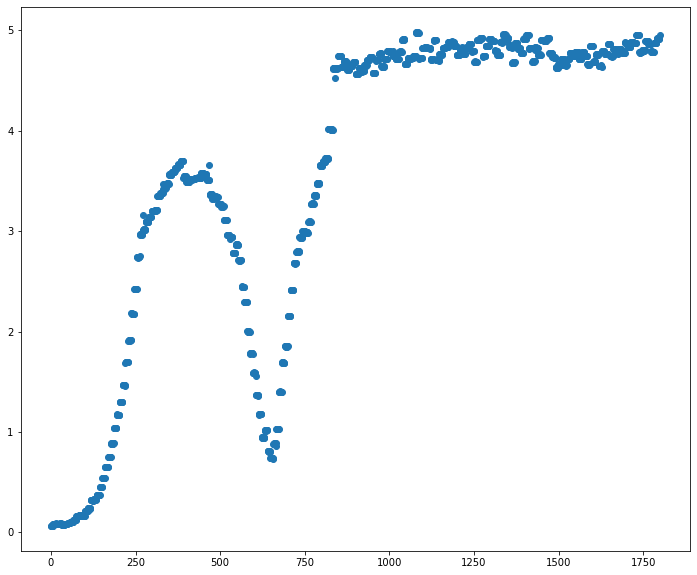

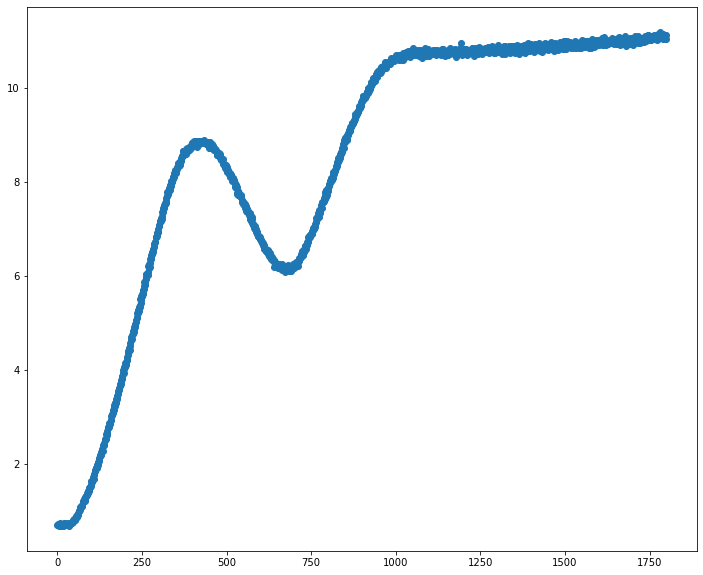

In [13]:
ok_file = 'MPC2_IM_L1/S42_P3/2018_09_07_06h/5b92a587_21442_45660_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, ok_file))
feature_std(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values])
#STD = X.std(axis=2)
MAX_MIN = X.max(axis=2) - X.min(axis=2)
#MEAN = X.mean(axis=2)
#X_test = np.zeros((1,1800,2))
#X_test[:,:,0] = MEAN
#X_test[:,:,1] = STD
X_test = MAX_MIN
result = vae.predict(X_test)
#result = result[:,:,1]
result = np.squeeze(result)

plt.figure(figsize=(12, 10))
plt.scatter(range(len(np.array(result))), result)
plt.show()

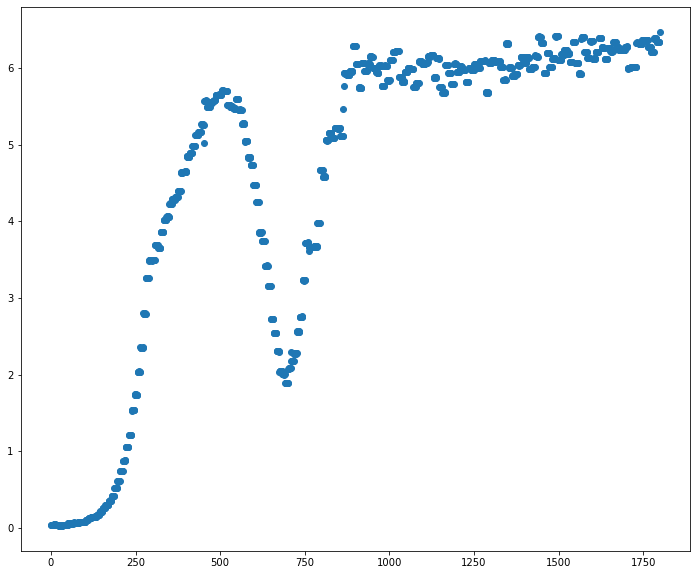

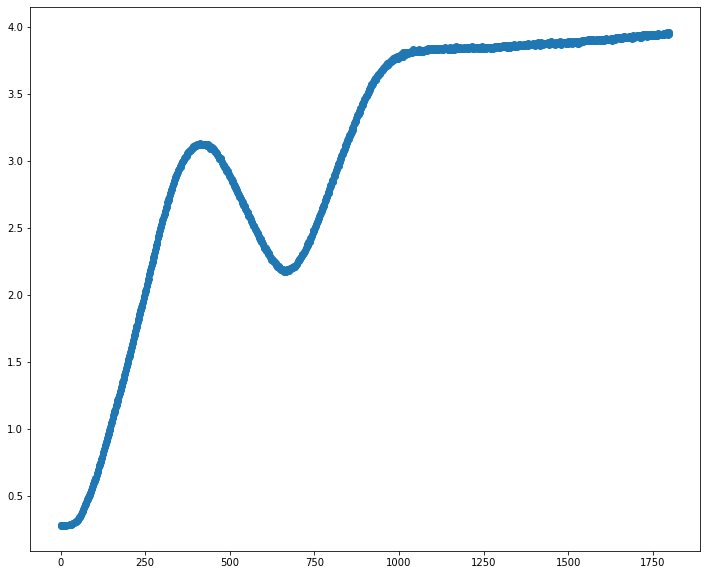

In [10]:
nok_file = 'MPC2_IM_L1/S42_P2/2018_08_25_09h/5b83eb9e_21782_28092_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, nok_file))
feature_std(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values])
X = X.std(axis=2)
result = vae.predict(X)
result = np.squeeze(result)

plt.figure(figsize=(12, 10))
plt.scatter(range(len(np.array(result))), result)
plt.show()

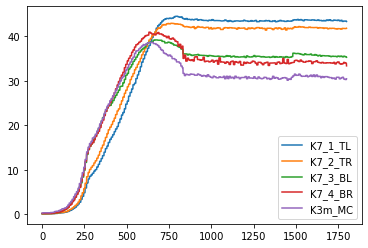

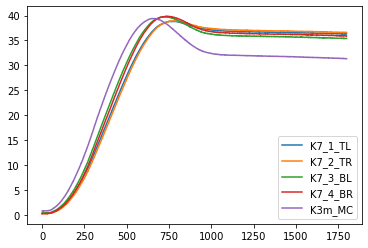

In [11]:
ok_file = 'MPC2_IM_L1/S42_P3/2018_09_07_06h/5b92a587_21442_45660_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, ok_file))
plot_curve(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values]) 
result = vae.predict(X)
result = np.squeeze(result)

result = result*X_std+X_mean


df_pred = pd.DataFrame(result, columns=["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]) 
plot_curve(df_pred)

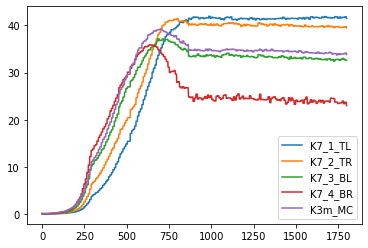

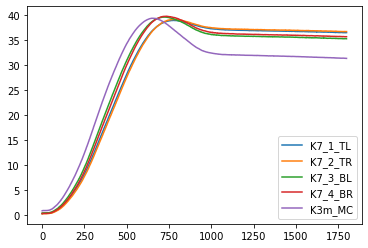

In [12]:
nok_file = 'MPC2_IM_L1/S42_P2/2018_08_25_09h/5b83eb9e_21782_28092_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, nok_file))
plot_curve(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values]) 
result = vae.predict(X)
result = np.squeeze(result)

result = result*X_std+X_mean


df_pred = pd.DataFrame(result, columns=["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]) 
plot_curve(df_pred)

## find threshold

In [9]:
#find NOK ratio
df_train = pd.read_csv('clean_train_5_pec_70_pec.csv')
#df_train = pd.read_csv('find_threshold.csv')
generator_train = CurveSequence(df_train, batch_size=1)

#recon_error = keras.Model(encoder_inputs, [tf.reduce_mean(reconstruction_loss)], name="recon_error")
recon_error = keras.Model(encoder_inputs, [z_mean_post, tf.exp(z_log_var_post)], name="recon_error")
result = recon_error.predict_generator(generator_train, workers=8, use_multiprocessing=True, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
52283/52283 [==============================] - 118s 2ms/step


## guassian model

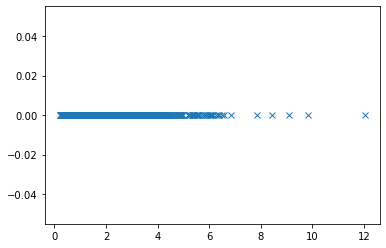

In [62]:
#use single gaussian
import numpy as np
import matplotlib.pyplot as pp

val = 0
pp.plot(result, np.zeros_like(result) + val, 'x')
pp.show()

(2, 1310)


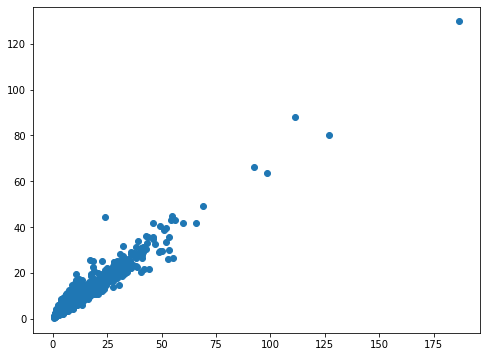

In [79]:
#use single gaussian
import numpy as np
import matplotlib.pyplot as pp
result = np.array(result)
print(np.shape(result))
plt.figure(figsize=(8,6))
plt.scatter(result[0,:],result[1,:]);
pp.show()

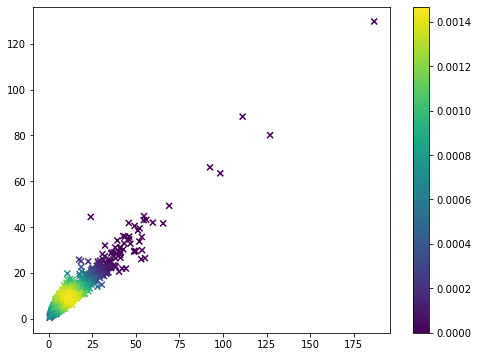

In [86]:
'''
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
gm.fit(result)
#plt.scatter(result[0,:],result[1,:],c=gm.predict_proba(result)[:,0],cmap='viridis',marker='x')
#print(gm.predict_proba(result)
'''

def estimateGaussian(X):
    m = X.shape[0]
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = (sum_/m)
    # compute variance of X
    var = np.var(X,axis=0)
    #print(mu, var)
    return mu,var

def multivariateGaussian(X, mu, sigma):
    k = len(mu)
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p
mu, sigma = estimateGaussian(result.transpose())
p = multivariateGaussian(result.transpose(), mu, sigma)
plt.figure(figsize=(8,6))
X = result.transpose()
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

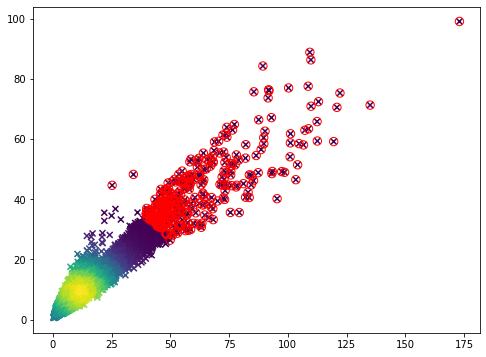

In [116]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
epsilon = 0.000002
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

## vae-gmm threshold

In [10]:
not_ok = df_train[df_train.ResultFinalCheck == 'NOK']
ok = df_train[df_train.ResultFinalCheck == 'OK']
print(not_ok.shape[0]/(ok.shape[0]+not_ok.shape[0]))
threshold=not_ok.shape[0]/(ok.shape[0]+not_ok.shape[0])

0.005929269552244516


In [11]:
print(np.shape(result[0]))

(52283, 90)


In [12]:
from scipy.stats import multivariate_normal

mu_hat, sigma_hat = result[0], result[1]
reconstructed_prob = np.zeros((52283,), dtype='float32')
L = 20 #sample 100 times
for l in range(L):
    print(l)
    mu_hat = mu_hat.reshape((52283, 90))
    sigma_hat = sigma_hat.reshape((52283, 90)) + 0.00001
    for i in range(52283):
        if i%10000 == 0:
            print(i)
        p_l = multivariate_normal.pdf(generator_train[i], mu_hat[i, :], np.diag(sigma_hat[i, :]))
        reconstructed_prob[i] += p_l
reconstructed_prob /= L

0
0
10000
20000
30000
40000
50000
1
0
10000
20000
30000
40000
50000
2
0
10000
20000
30000
40000
50000
3
0
10000
20000
30000
40000
50000
4
0
10000
20000
30000
40000
50000
5
0
10000
20000
30000
40000
50000
6
0
10000
20000
30000
40000
50000
7
0
10000
20000
30000
40000
50000
8
0
10000
20000
30000
40000
50000
9
0
10000
20000
30000
40000
50000
10
0
10000
20000
30000
40000
50000
11
0
10000
20000
30000
40000
50000
12
0
10000
20000
30000
40000
50000
13
0
10000
20000
30000
40000
50000
14
0
10000
20000
30000
40000
50000
15
0
10000
20000
30000
40000
50000
16
0
10000
20000
30000
40000
50000
17
0
10000
20000
30000
40000
50000
18
0
10000
20000
30000
40000
50000
19
0
10000
20000
30000
40000
50000


In [17]:
print(reconstructed_prob)

[0. 0. 0. ... 0. 0. 0.]


In [13]:
judge_loss = np.percentile(reconstructed_prob,(1-threshold)*100)

In [14]:
print(judge_loss)

0.0


In [15]:
np.min(reconstructed_prob)

0.0

In [16]:
np.max(reconstructed_prob)

0.0

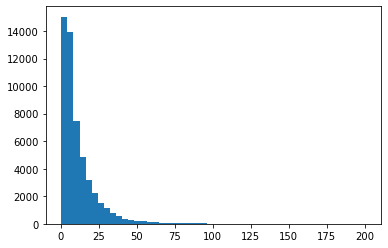

In [62]:
from matplotlib import pyplot as plt

plt.hist(reconstructed_prob, 50) # bins = 50，顺便可以控制bin宽度
plt.show()

## Test on valid dataset

In [63]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
    def draw_error(self, error, threshold):
        plt.figure(figsize=(10, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='',
                 label='Point')

        plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="r", zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

In [64]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels,title):
    cmap = plt.cm.binary
    cm = confusion_matrix(y_true, y_pred)
    tick_marks = np.array(range(len(labels))) + 0.5
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(4, 2), dpi=120)
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array)
    intFlag = 0 
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        #

        if (intFlag):
            c = cm[y_val][x_val]
            plt.text(x_val, y_val, "%d" % (c,), color='red', fontsize=8, va='center', ha='center')

        else:
            c = cm_normalized[y_val][x_val]
            if (c > 0.01):
                plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
            else:
                plt.text(x_val, y_val, "%d" % (0,), color='red', fontsize=7, va='center', ha='center')
    if(intFlag):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    else:
        plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels)
    plt.yticks(xlocations, labels)
    plt.ylabel('Index of True Classes')
    plt.xlabel('Index of Predict Classes')
    plt.show()

In [50]:
#valid set test
df_valid = pd.read_csv('clean_test_5_pec_30_pec.csv')
valid_y = df_valid['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
generator_valid = CurveSequence(df_valid, batch_size=1)

recon_error = keras.Model(encoder_inputs, [z_mean_post, tf.exp(z_log_var_post)], name="recon_error")
predict_valid = recon_error.predict_generator(generator_valid, workers=8, use_multiprocessing=True, verbose=1)

13071/13071 [==============================] - 31s 2ms/step


In [ ]:
mu_hat, sigma_hat = recon_error[0], recon_error[1]
reconstructed_prob_valid = np.zeros((13071,), dtype='float32')
L = 100 #sample 100 times
for l in range(L):
    mu_hat = mu_hat.reshape((13071, 1800))
    sigma_hat = sigma_hat.reshape((13071, 1800)) + 0.00001
    for i in range(13071):
        p_l = multivariate_normal.pdf(X[i, :], mu_hat[i, :], np.diag(sigma_hat[i, :]))
        reconstructed_prob_valid[i] += p_l
reconstructed_prob_valid /= L

## gaussian model

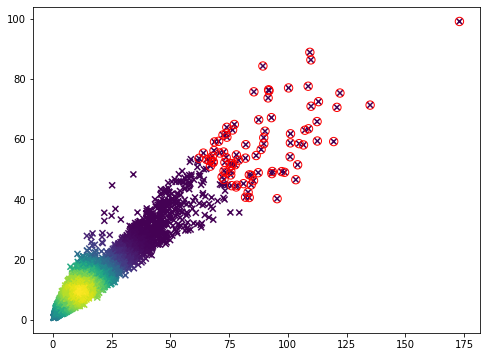

In [140]:
predict_valid = np.array(predict_valid)
X = predict_valid.transpose()
p = multivariateGaussian(X, mu, sigma)
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
epsilon = 0.000000000001
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

In [141]:
print(np.shape(outliers))

(87,)


## test valid

In [65]:
val_result = []
for i in range(len(reconstructed_prob_valid)):
    if reconstructed_prob_valid[i] > judge_loss:
        val_result.append(0)
    else:
        val_result.append(1)

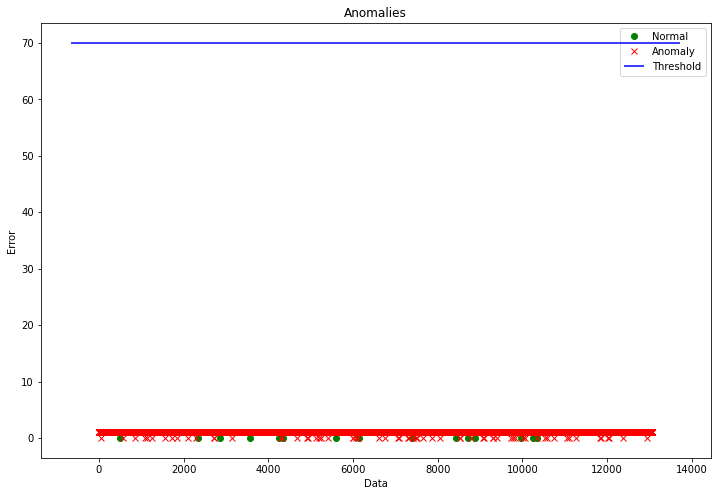

In [66]:
viz = Visualization()
viz.draw_anomaly(valid_y, val_result, judge_loss)

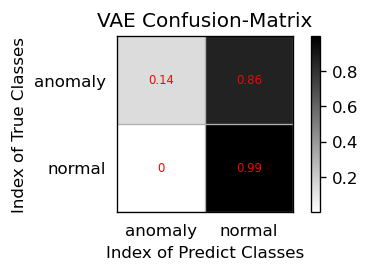

In [67]:
plot_confusion_matrix(valid_y, val_result, ['anomaly','normal'],'VAE Confusion-Matrix')

In [68]:
def compute_score(pred, gt):
    n_false_positives = 0
    n_true_positives = 0
    for i in range(len(pred)):
        if pred[i] == 1 and gt[i] == 0:
            n_false_positives = n_false_positives + 1
        if pred[i] == 0 and gt[i] == 0:
            n_true_positives = n_true_positives + 1
    print(n_false_positives, n_true_positives)
    return 1000*(0.42*n_true_positives - n_false_positives) / len(pred)

In [69]:
print(compute_score(val_result, valid_y))

90 15
-6.40348863897177


## detect on test data

In [32]:
df_test = pd.read_csv('sample_submission.csv')
df_test.head()

,FilePath,Decision
0,MPC2_IM_L2/S42_P4/2019_01_10_03h/5c36c122_3113...,OK
1,MPC2_IM_L1/S42_P3/2019_02_05_20h/5c5a888f_2022...,OK
2,MPC2_IM_L1/S42_42/2018_10_22_04h/5bcdaaa8_2041...,OK
3,MPC2_IM_L3/S42_P3/2019_02_06_01h/5c5a5dee_3255...,OK
4,MPC2_IM_L2/S42_P2/2018_09_06_21h/5b9238fe_3092...,OK


In [27]:
df_test.shape

(561423, 2)

In [33]:
generator_test = CurveSequence(df_test, batch_size=1)
recon_error = keras.Model(encoder_inputs, [tf.reduce_mean(reconstruction_loss)], name="recon_error")
predict = recon_error.predict_generator(generator_test, workers=4, use_multiprocessing=True, verbose=1)

561423/561423 [==============================] - 1225s 2ms/step


In [34]:
result = []
for i in range(len(predict)):
    if predict[i] > judge_loss:
        result.append('NOK')
    else:
        result.append('OK')

In [35]:
path_name = df_test['FilePath']
cont_list = {'FilePath':path_name, 'Decision':result}
df = pd.DataFrame(cont_list, columns=['FilePath','Decision'])
df.to_csv('jst.csv')

In [36]:
print(judge_loss)

56.44758986553167
